# Importing libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Loading data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')
train_df.iloc[0:5,0:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea
0,1,60,RL,65.0,8450
1,2,20,RL,80.0,9600
2,3,60,RL,68.0,11250
3,4,70,RL,60.0,9550
4,5,60,RL,84.0,14260


# Exploring data

In [ ]:
# the describtion
train_df[[
    'MiscVal',
    'SalePrice']].describe(include="all")


,MiscVal,SalePrice
count,1460.000000,1460.000000
mean,43.489041,180921.195890
std,496.123024,79442.502883
min,0.000000,34900.000000
25%,0.000000,129975.000000
50%,0.000000,163000.000000
75%,0.000000,214000.000000
max,15500.000000,755000.000000


In [ ]:
# Count None values
train_df[['TotalBsmtSF']].isna().sum()

,0
TotalBsmtSF,0


In [ ]:
#exploring info of the data
train_df.iloc[:,15:20].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   HouseStyle    1460 non-null   object
 1   OverallQual   1460 non-null   int64 
 2   OverallCond   1460 non-null   int64 
 3   YearBuilt     1460 non-null   int64 
 4   YearRemodAdd  1460 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 68.4+ KB


In [ ]:
# measure correlation
train_df[[
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
              'SalePrice']].corr()

,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,SalePrice
BedroomAbvGr,1.000000,0.198597,0.676620,0.168213
KitchenAbvGr,0.198597,1.000000,0.256045,-0.135907
TotRmsAbvGrd,0.676620,0.256045,1.000000,0.533723
SalePrice,0.168213,-0.135907,0.533723,1.000000


In [ ]:
# Count the Values of the column
train_df['CentralAir'].value_counts()


,count
CentralAir,
Y,1365
N,95


# Data cleaning and encoding

In [3]:
# fill missing values
train_df['LotFrontage'] =train_df['LotFrontage'].fillna(train_df['LotFrontage'].mean())

test_df['LotFrontage'] = test_df['LotFrontage'].fillna(test_df['LotFrontage'].mean())


In [4]:
# Encoding data
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
train_df['ExterQual_encoded'] = train_df['ExterQual'].map(quality_map)
train_df['BsmtQual_encoded'] = train_df['BsmtQual'].map(quality_map)

test_df['ExterQual_encoded'] = test_df['ExterQual'].map(quality_map)
test_df['BsmtQual_encoded'] = test_df['BsmtQual'].map(quality_map)


In [5]:
# Creating the 'AllBathNum' which sum the total bath numbers
train_df['AllBathNum'] = (
    train_df['FullBath'] +
    train_df['HalfBath'] * 0.5 +
    train_df['BsmtFullBath'] +
    train_df['BsmtHalfBath'] * 0.5
)

test_df['AllBathNum'] = (
    test_df['FullBath'] +
    test_df['HalfBath'] * 0.5 +
    test_df['BsmtFullBath'] +
    test_df['BsmtHalfBath'] * 0.5
)


# Output

In [22]:
  #export queries  to csv files
train_df = train_df.reset_index()
train_df[[
    'Id', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'GrLivArea', 'AllBathNum', 'TotRmsAbvGrd',
              'SalePrice']].to_csv('train_Q1.csv')
train_df[[
    'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'ExterQual_encoded', 'BsmtQual_encoded', 'TotalBsmtSF', 'GrLivArea', 'AllBathNum', 'TotRmsAbvGrd',
    'SalePrice']].corr()['SalePrice'].to_csv('train_Q2.csv')

In [6]:
#get data for model

X = train_df[[
    'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'ExterQual_encoded', 'BsmtQual_encoded', 'TotalBsmtSF', 'GrLivArea', 'AllBathNum', 'TotRmsAbvGrd'
    ]].astype('float').fillna(0)

Y = train_df['SalePrice'].astype('float').fillna(0)

test_data = test_df[[
    'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'ExterQual_encoded', 'BsmtQual_encoded', 'TotalBsmtSF', 'GrLivArea', 'AllBathNum',
    'TotRmsAbvGrd'
    ]].astype('float').fillna(0)


# Prepare data to model

In [7]:
# split data to train and test samples
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
# Normalize data (StandardScaler)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

test_data_scaled = scaler.fit_transform(test_data)

## Building models

In [9]:
  # Ridge regression
  ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_model = Ridge()
ridge_cv = GridSearchCV(ridge_model, ridge_params, cv=5)
ridge_cv.fit(X_train_scaled, Y_train)

ridge_best = ridge_cv.best_estimator_
ridge_pred = ridge_best.predict(X_test_scaled)


In [10]:
# Ridge measures
ridge_best.score(X_test_scaled, Y_test)

0.8014671601723199

In [11]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_model = RandomForestRegressor(random_state=42)
rf_cv = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1)
rf_cv.fit(X_train_scaled, Y_train)

rf_best = rf_cv.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)


In [12]:
# Random Forest measures
rf_best.score(X_test_scaled, Y_test)

0.8721535711098293

In [13]:
#  XGBoost model
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_cv = GridSearchCV(xgb_model, xgb_params, cv=5, n_jobs=-1)
xgb_cv.fit(X_train, Y_train)

xgb_best = xgb_cv.best_estimator_
xgb_pred = xgb_best.predict(X_test)

In [14]:
#  XGBoost measures
xgb_best.score(X_test, Y_test)

0.8961313212217557

In [15]:
# Evaluating models
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt  (mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n  RMSE: {rmse:.2f}\n  R²: {r2:.4f}\n")

evaluate(Y_test, ridge_pred, "Ridge Regression")
evaluate(Y_test, rf_pred, "Random Forest")
evaluate(Y_test, xgb_pred, "XGBoost")


Ridge Regression:
  RMSE: 39023.22
  R²: 0.8015

Random Forest:
  RMSE: 31314.91
  R²: 0.8722

XGBoost:
  RMSE: 28225.99
  R²: 0.8961



In [16]:
# create a data frame to compare models
# Create empty list to collect results
results = []

# Define evaluation function
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    results.append({
        'Model': name,
        'RMSE': rmse,
        'R² Score': r2
    })

# Evaluate all models
evaluate_model("Ridge Regression", Y_test, ridge_pred)
evaluate_model("Random Forest", Y_test, rf_pred)
evaluate_model("XGBoost", Y_test, xgb_pred)

# Create DataFrame and export to csv file
models_comparison_df = pd.DataFrame(results)
models_comparison_df.to_csv('models_comparison.csv')

# Show results
models_comparison_df


,Model,RMSE,R² Score
0,Ridge Regression,39023.219297,0.801467
1,Random Forest,31314.913604,0.872154
2,XGBoost,28225.992435,0.896131


# Predict sale price for test data

In [21]:
# predict price and assign to the data frame
test_df['PredictedPrice'] = xgb_best.predict(test_data)

# export answer to csv
test_df[['Id', 'PredictedPrice']].to_csv('answer.csv')
test_df[['Id', 'PredictedPrice']].describe().to_csv('answer_description.csv')

# Show description
test_df[['Id', 'PredictedPrice']].describe()

,Id,PredictedPrice
count,1459.000000,1459.000000
mean,2190.000000,178436.953125
std,421.321334,74468.546875
min,1461.000000,54323.812500
25%,1825.500000,128267.023438
50%,2190.000000,158066.515625
75%,2554.500000,209190.039062
max,2919.000000,525920.000000


# Dashboard

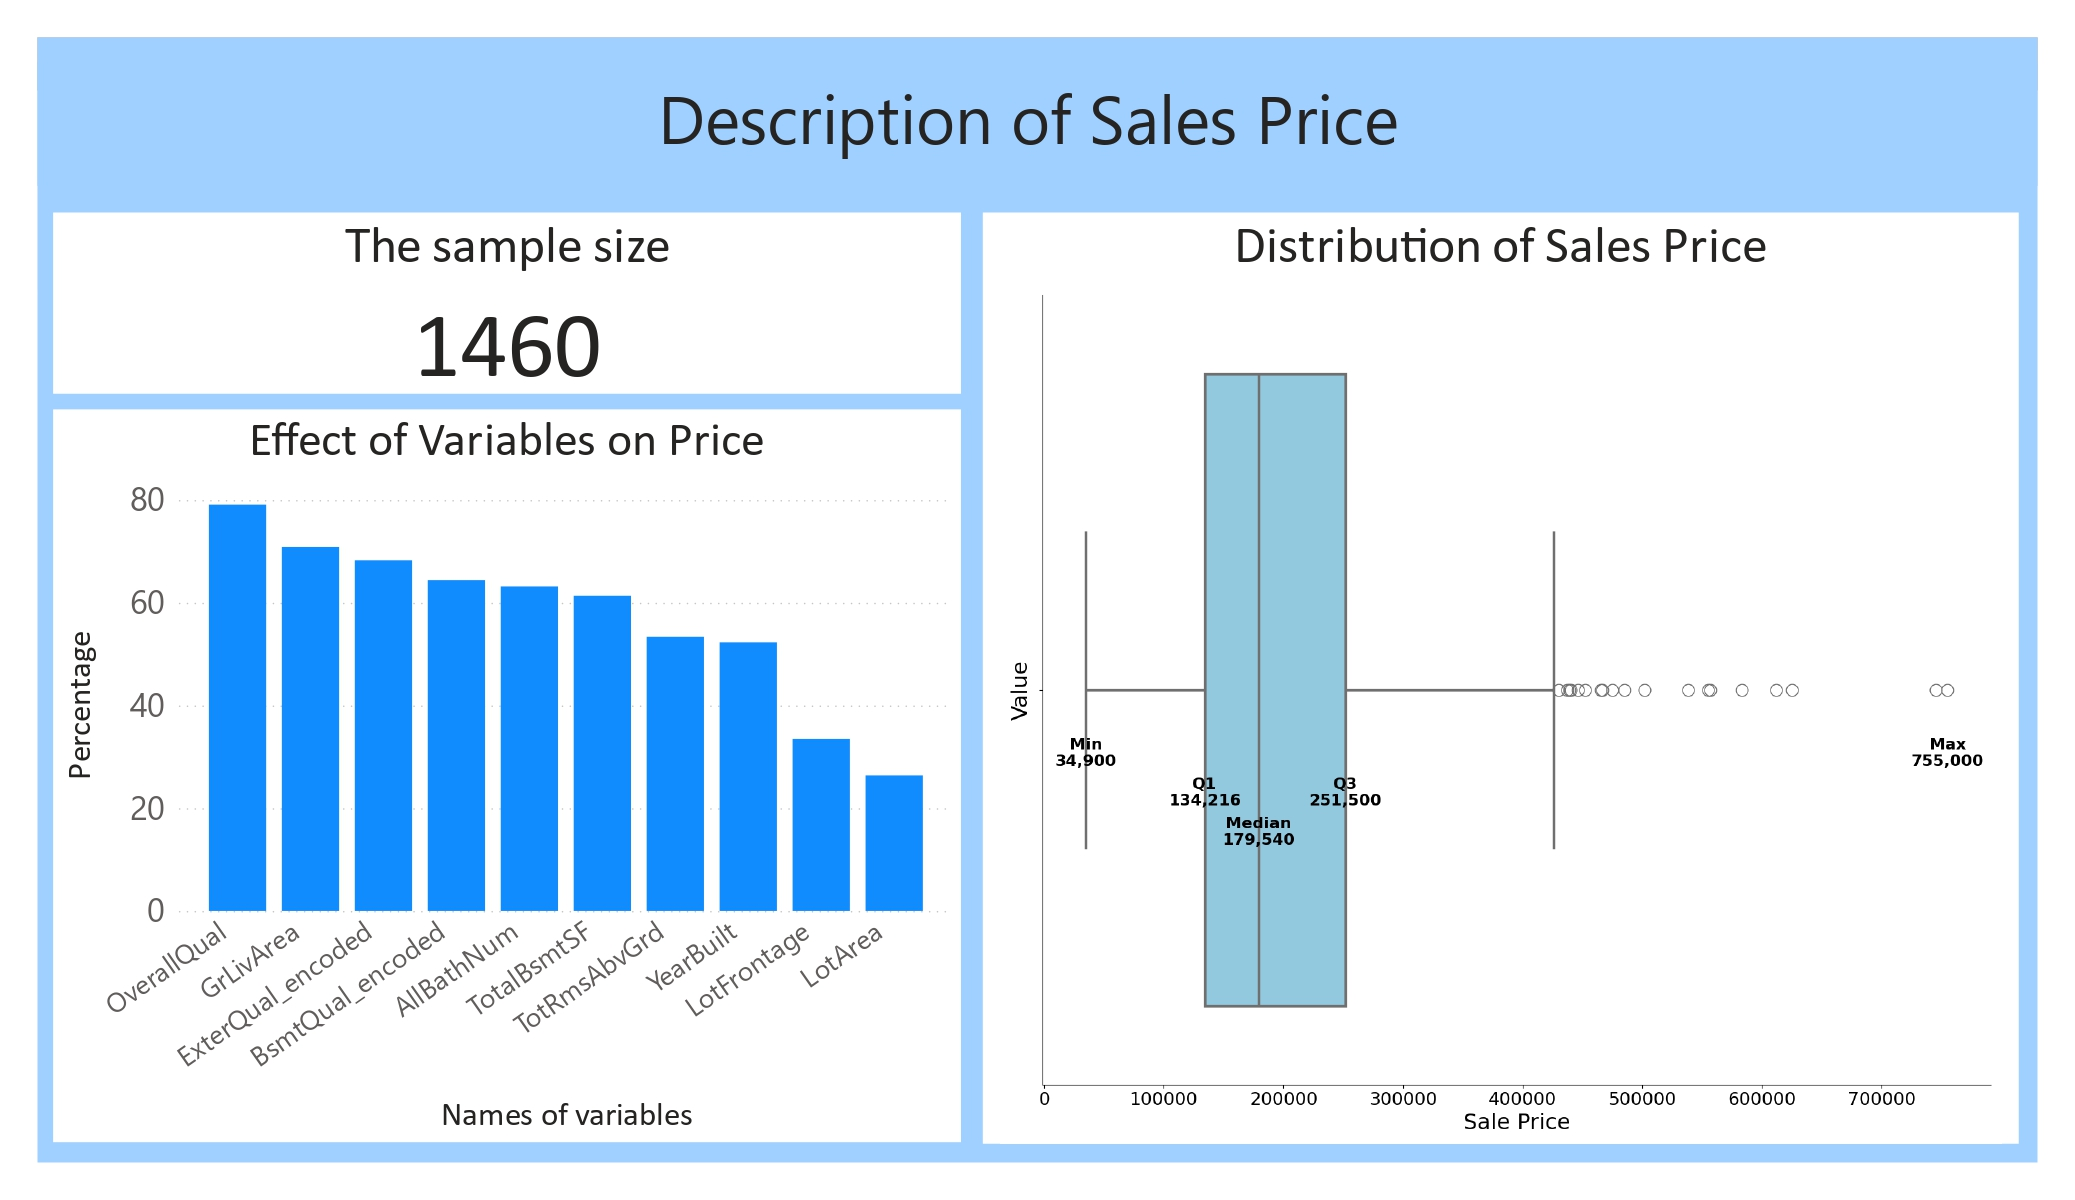

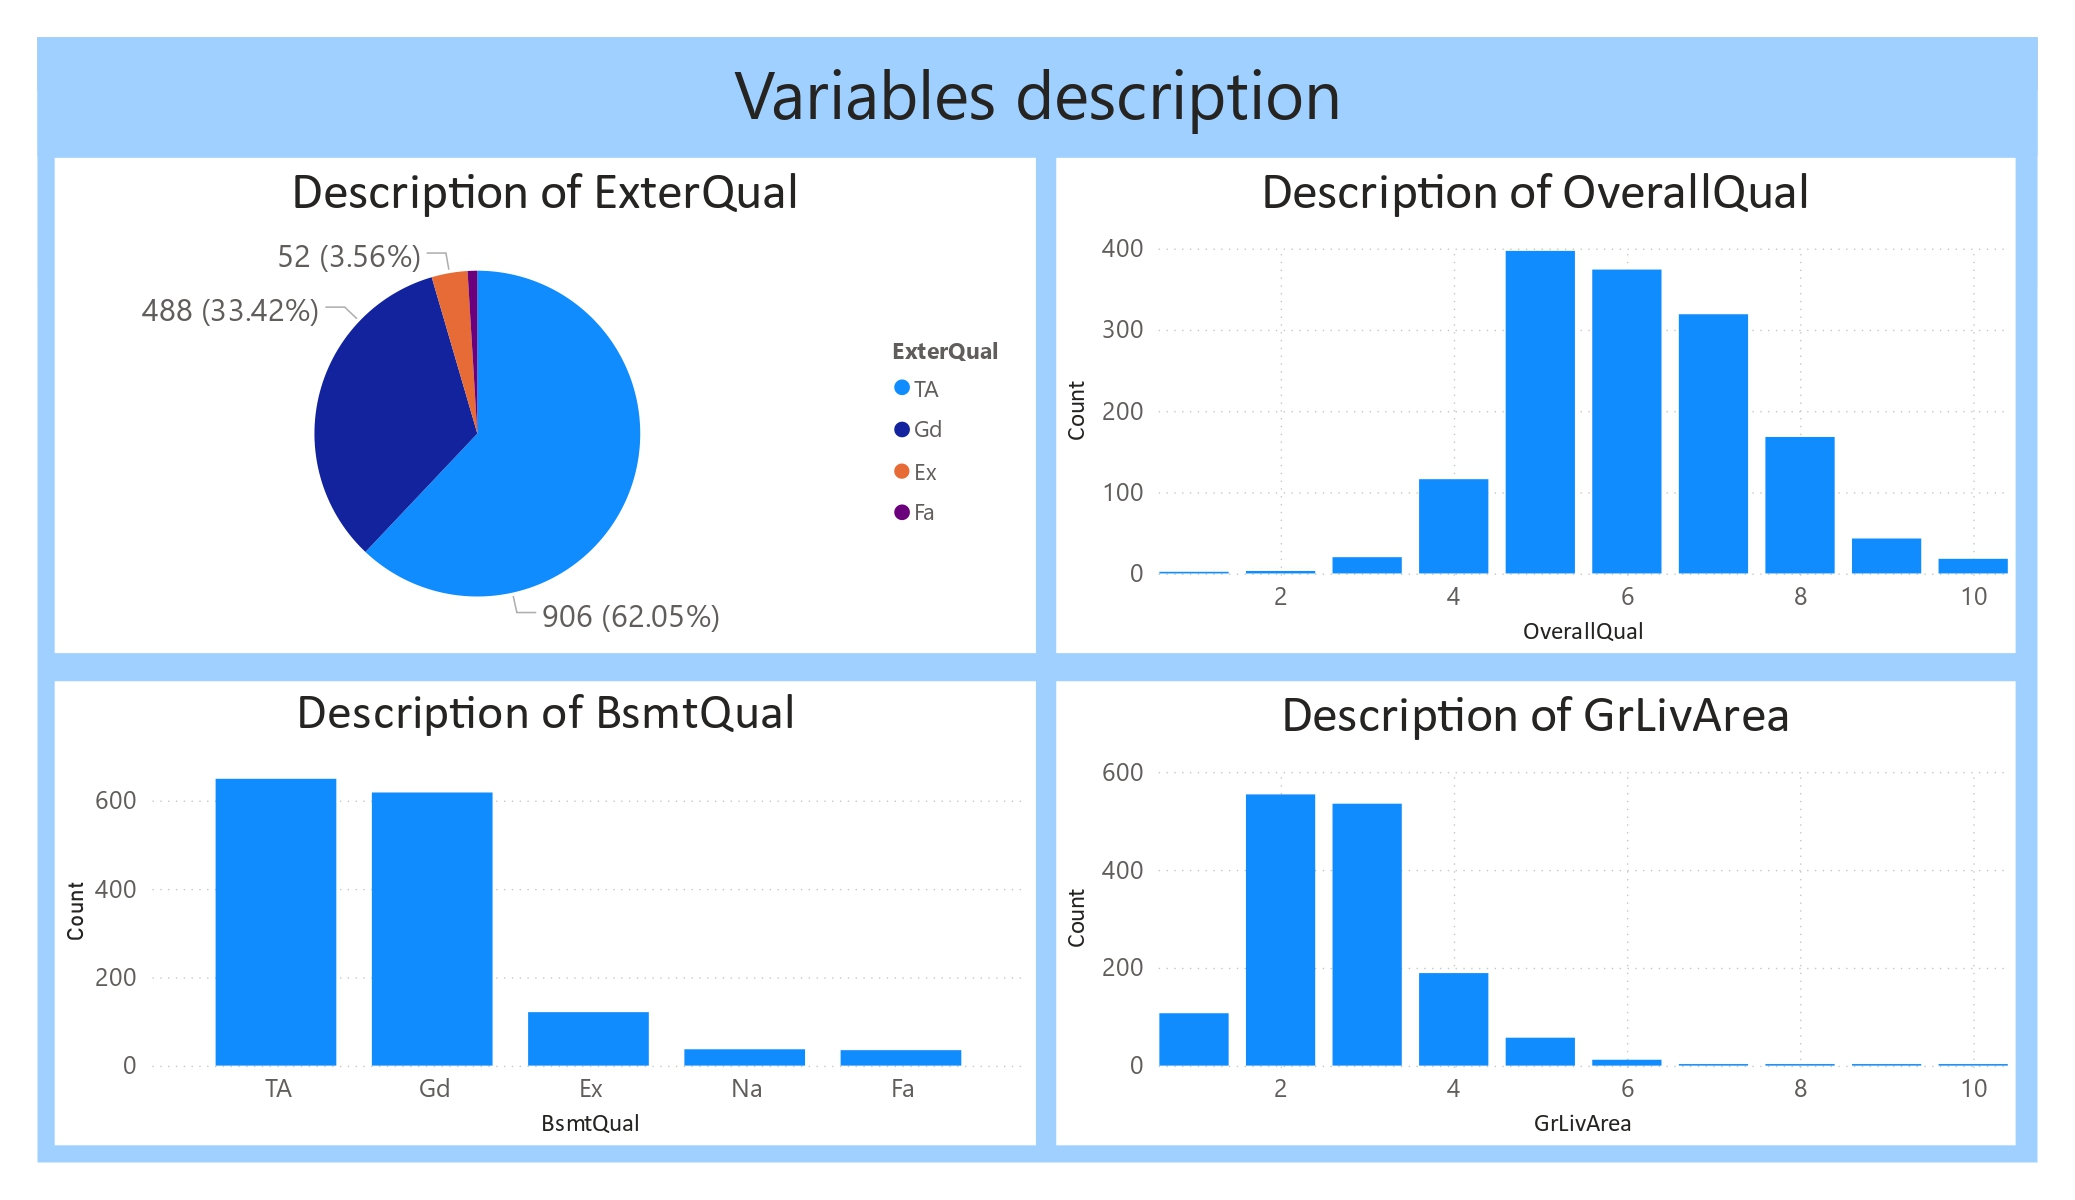

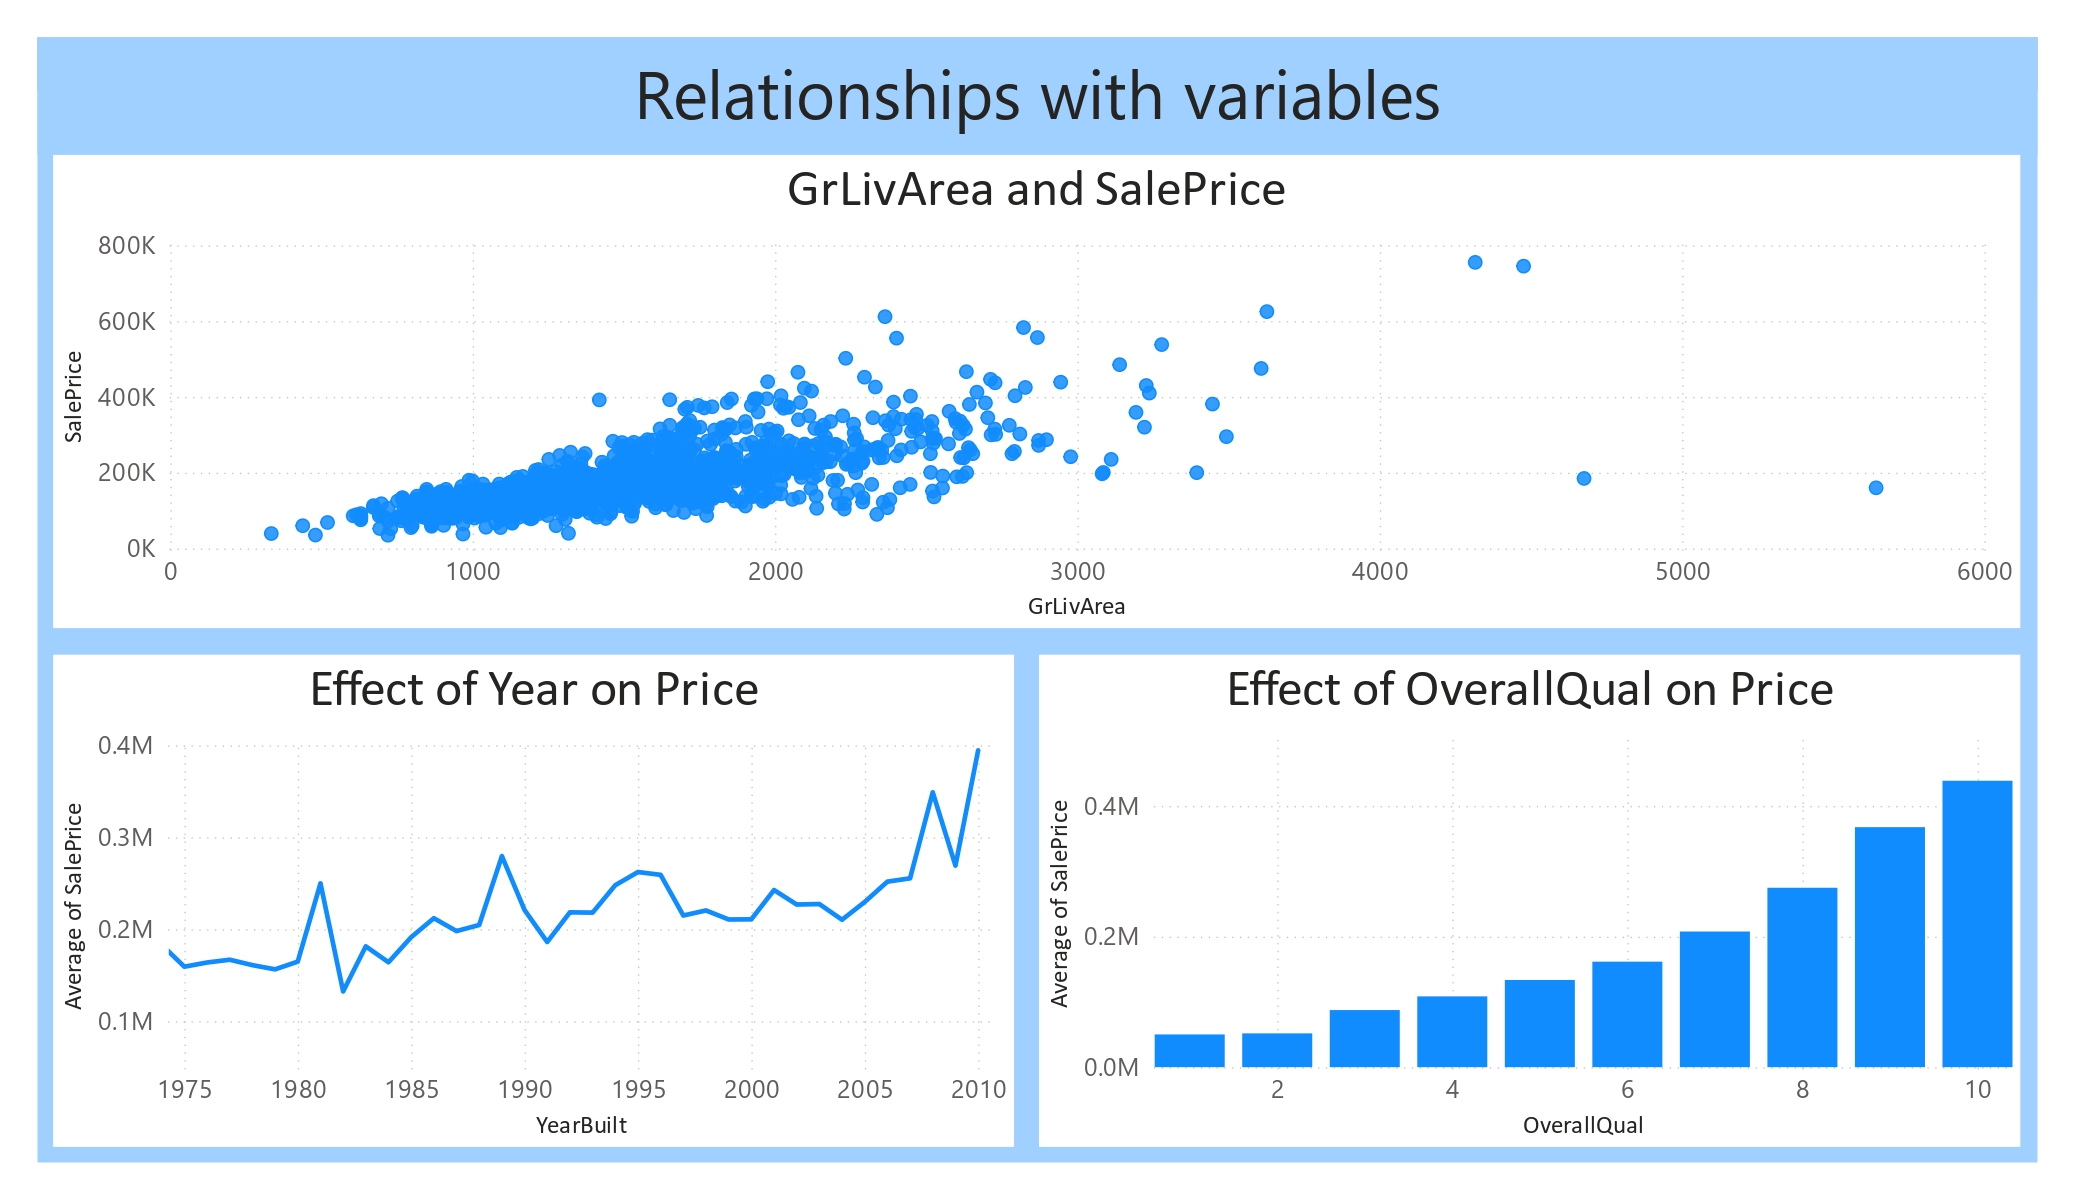